In [1]:
# Library includes
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random

In [2]:
# Helper functions

from model_functions import *

from visualize_results import *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get the data
import requests
import zipfile
from pathlib import Path
import tqdm

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "CATANIST V1"

# Download CATANIST dataset
if image_path.is_dir():
  print(f"{image_path} already exists, skipping download...")
else:
  with open(data_path / "CATANIST V1.zip", "wb") as f:
    request = requests.get("https://github.com/mattmanb/catanomics/raw/main/data/CATANIST%20V1.zip")
    print(f"Downloading CATANIST zip file...")
    f.write(request.content)

  # Unzip CATANIST dataset
  with zipfile.ZipFile(data_path / "CATANIST V1.zip", "r") as zip_ref:
    print("Unzipping CATANIST data...")
    zip_ref.extractall(data_path)

data/CATANIST V1 already exists, skipping download...


In [4]:
# Examine 
import os
def walk_through_dir(dir_path):
    """Walks through dir_path, returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(data_path)

There are 1 directories and 1 images in data
There are 2 directories and 1 images in data/CATANIST V1
There are 10 directories and 1 images in data/CATANIST V1/test
There are 0 directories and 4 images in data/CATANIST V1/test/eight
There are 0 directories and 4 images in data/CATANIST V1/test/eleven
There are 0 directories and 4 images in data/CATANIST V1/test/nine
There are 0 directories and 4 images in data/CATANIST V1/test/three
There are 0 directories and 4 images in data/CATANIST V1/test/ten
There are 0 directories and 4 images in data/CATANIST V1/test/twelve
There are 0 directories and 4 images in data/CATANIST V1/test/two
There are 0 directories and 4 images in data/CATANIST V1/test/six
There are 0 directories and 4 images in data/CATANIST V1/test/five
There are 0 directories and 4 images in data/CATANIST V1/test/four
There are 10 directories and 1 images in data/CATANIST V1/train
There are 0 directories and 70 images in data/CATANIST V1/train/eight
There are 0 directories and 

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/CATANIST V1/train'), PosixPath('data/CATANIST V1/test'))

In [159]:
from torchvision.transforms import v2

# Create any data transforms I want to try

# Simple transform (size, ToTensor)
data_transform_0 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch tensor
    transforms.ToTensor(),
])

# TrivialAugmentWide
data_transform_1 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # Try trivialaugment
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # Turn the image into a torch tensor
    transforms.ToTensor(),
])

# Random horizontal and verticle flips, as well as guassian blur
data_transform_2 = v2.Compose([
    v2.RandomZoomOut(fill=0, side_range=(1, 1.5)),
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomRotation(degrees=180,interpolation=transforms.InterpolationMode.BILINEAR),
    v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 3))], p=.9),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])



### Visualize the transforms

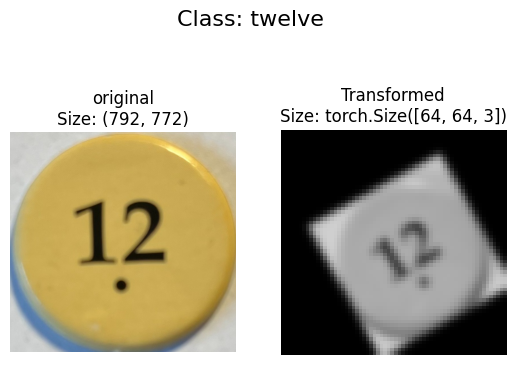

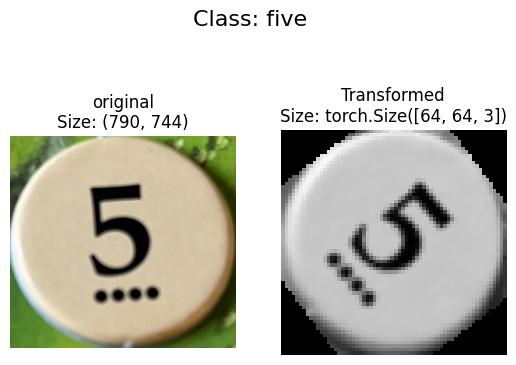

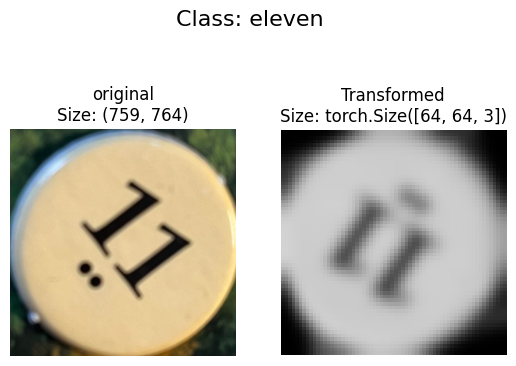

In [160]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
# plot_transformed_images(image_paths=image_path_list, transform=data_transform_0, n=3)
plot_transformed_images(image_paths=image_path_list, transform=data_transform_2, n=3, seed=None)
# plot_transformed_images(image_paths=image_path_list, transform=data_transform_2, n=3)

### Create the datasets using ImageFolder

In [161]:
from torchvision import datasets

# Try different transforms here!
current_transform = data_transform_2

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=current_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=current_transform,
                                 target_transform=None)
class_names = train_data.classes

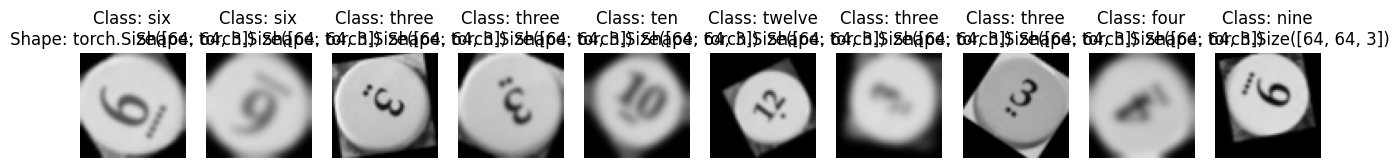

In [162]:
display_random_images(dataset=train_data, 
                      classes=class_names,
                      n=10,
                      display_shape=True)

### Create DataLoaders for the datasets

In [163]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16d439790>,
 <torch.utils.data.dataloader.DataLoader at 0x2fe25a450>)

### Creating a model

In [164]:
import torch
from torch import nn

device = ("cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
device

'mps'

#### TinyVGG Architecture (used previously, didn't work great)

In [165]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2) # Default stride in a MaxPool2d layer is the kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2) # Default stride in a MaxPool2d layer is the kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*12*12, # this layer was determined by printing out shapes of previous layer in section 6.3
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"x shape after conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"x shape after conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"x shape after classifier: {x.shape}")
    return x

#### CNN architecture of MNIST

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class Simple_CNN(nn.Module):
#     def __init__(self, 
#                  input_shape:int,
#                  hidden_units:int,
#                  output_shape:int) -> None:
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1) # Assuming grayscale images
#         self.bn1 = nn.BatchNorm2d(hidden_units)
#         self.conv2 = nn.Conv2d(hidden_units, hidden_units, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(hidden_units)
#         self.conv3 = nn.Conv2d(hidden_units, hidden_units, 3, padding=1)
#         self.bn3 = nn.BatchNorm2d(hidden_units)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # self.fc1 = nn.Linear(hidden_units * 16 * 16, 512) # Adjust the input size based on your image size
#         # self.fc2 = nn.Linear(512, output_shape)
#         self.dropout = nn.Dropout(0.5)
#         self.flat = nn.Flatten()
#         self.out = nn.Linear(in_features=hidden_units*8*8,
#                              out_features=output_shape)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # print(f"x shape after conv block 1: {x.shape}")
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         # print(f"x shape after conv block 2: {x.shape}")
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         # print(f"x shape after conv block 3: {x.shape}")
#         # x = x.view(-1, 64 * 16 * 16) # Flatten the output for the fully connected layer
#         x = self.dropout(x)
#         x = self.flat(x)
#         x = self.out(x)
#         return x


class Simple_CNN(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape:int) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=input_shape,              
                out_channels=hidden_units,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # fully connected layer, output 10 classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, 
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        x = self.conv2(x)
        # print(f"x shape after conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"x shape after classifier: {x.shape}")
        return x    # return x for visualization

### ResNet Architecture

#### Define the blocks

In [167]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape: int, output_shape:int, stride=1) -> None:
        super(BasicBlock, self).__init__()
        # Conv layer 1
        self.conv1 = nn.Conv2d(input_shape, 
                               output_shape, 
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        # Batch norm 1
        self.bn1 = nn.BatchNorm2d(output_shape)
        # Activation
        self.relu = nn.ReLU(inplace=True)
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(output_shape, 
                               output_shape,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        # Batch norm 2
        self.bn2 = nn.BatchNorm2d(output_shape)
        
        # Account for differences in stride length if not 1 & num filters
        self.downsample = nn.Sequential()
        if stride != 1 or input_shape != output_shape:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_shape, output_shape,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(output_shape)
            )
    def forward(self, x):
        identity = x
        logits = self.conv1(x)
        logits = self.bn1(logits)
        logits = self.relu(logits)
        logits = self.conv2(logits)
        logits = self.bn2(logits)
        logits += self.downsample(identity)
        logits = self.relu(logits)
        return logits
        

#### Create ResNet

In [168]:
class ResNet(nn.Module):
    def __init__(self, input_shape, block, layers, class_cnt):
        super(ResNet, self).__init__()
        self.num_classes = class_cnt
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=input_shape, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Create 3 'blocks'
        self.block1 = self.make_layer(block, 64, layers[0], stride=1)
        self.block2 = self.make_layer(block, 128, layers[1], stride=2)
        self.block3 = self.make_layer(block, 256, layers[2], stride=2)
        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(256, class_cnt)
    def make_layer(self, block, output_shape, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, output_shape, stride))
        self.in_channels = output_shape
        for _ in range(1, blocks):
            layers.append(block(output_shape, output_shape, stride=1))
        return nn.Sequential(*layers)
    def forward(self, x):
        logits = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        logits = self.bn1(logits)
        # print(f"x shape after batch norm 1: {x.shape}")
        logits = self.relu(logits)
        logits = self.block1(logits)
        # print(f"x shape after res block 1: {x.shape}")
        logits = self.block2(logits)
        # print(f"x shape after res block 2: {x.shape}")
        logits = self.block3(logits)
        # print(f"x shape after res block 3: {x.shape}")
        logits = self.avg_pool(logits)
        logits = logits.view(logits.size(0), -1)
        logits = self.fc(logits)
        return logits

In [169]:
model = ResNet(input_shape=3, 
               block=BasicBlock,
               layers=[2, 2, 2],
               class_cnt=len(class_names)).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [170]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape
model(image_batch.to(device))

tensor([[-1.9679e-02, -6.2576e-03,  4.7492e-01, -5.9957e-03,  2.8402e-01,
          2.2521e-01, -6.0952e-01,  5.3910e-01,  1.9014e-01,  5.2185e-01],
        [-2.0677e-01, -3.6879e-02,  4.7281e-01, -2.9799e-01,  5.1859e-01,
          3.6826e-03, -7.7257e-01,  7.7240e-01,  2.7648e-01,  6.3161e-01],
        [-1.5303e-01, -1.6049e-01,  4.7057e-01, -3.4373e-01,  5.4614e-01,
          3.7590e-02, -8.9026e-01,  8.9960e-01,  3.0869e-01,  7.0266e-01],
        [ 1.2619e-02, -2.9381e-02,  2.6629e-01, -7.9537e-03,  2.2044e-01,
          2.6463e-01, -5.4731e-01,  5.3886e-01,  2.0350e-01,  5.1508e-01],
        [ 4.9652e-03, -2.9127e-02,  2.8844e-01, -6.3481e-02,  2.1633e-01,
          2.6891e-01, -5.4144e-01,  5.4029e-01,  1.6849e-01,  5.0064e-01],
        [-3.9951e-02, -4.5166e-02,  4.0815e-01, -1.0193e-01,  2.8645e-01,
          1.5925e-01, -6.4166e-01,  5.8598e-01,  2.1647e-01,  5.6210e-01],
        [-8.2022e-02,  2.4895e-03,  3.9584e-01, -1.1955e-01,  3.2867e-01,
          1.4255e-01, -5.9272e-0

### Train the model

In [171]:
# Hyperparameters (Batch size is in cell 10)
EPOCHS = 25
INPUT_SHAPE = 3
HIDDEN_UNITS = 10
OUTPUT_SHAPE = len(class_names)
LEARNING_RATE = 0.001
LOSS_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

simple_train = False
VGG_train = False
ResNet_train = True

In [172]:
### Train simple CNN
if simple_train:
    model_simple = Simple_CNN(input_shape=INPUT_SHAPE,
                        hidden_units=HIDDEN_UNITS,
                        output_shape=OUTPUT_SHAPE).to(device)

    simple_optimizer = optimizer(params=model_simple.parameters(), lr=LEARNING_RATE)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train simple model
    model_simple_results = train(model=model_simple,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=simple_optimizer,
                                loss_fn=LOSS_FN,
                                epochs=EPOCHS,
                                device=device)

    # End the timer
    end_time = timer()
    print(f"Simple training time: {end_time-start_time:.3f} seconds")
else:
    print("Skipping simple CNN training for now...")

Skipping simple CNN training for now...


In [173]:
### Train VGG
if VGG_train:
    model_VGG = TinyVGG(input_shape=INPUT_SHAPE,
                        hidden_units=HIDDEN_UNITS,
                        output_shape=OUTPUT_SHAPE).to(device)

    VGG_optimizer = optimizer(params=model_VGG.parameters(), lr=LEARNING_RATE)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train simple model
    model_VGG_results = train(model=model_VGG,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=VGG_optimizer,
                                loss_fn=LOSS_FN,
                                epochs=EPOCHS,
                                device=device)

    # End the timer
    end_time = timer()
    print(f"VGG training time: {end_time-start_time:.3f} seconds")
else:
    print("Skipping VGG training for now...")

Skipping VGG training for now...


In [174]:
### Train ResNet
if ResNet_train:
    model_resnet = ResNet(input_shape=INPUT_SHAPE, 
                        block=BasicBlock,
                        layers=[2, 2, 2],
                        class_cnt=OUTPUT_SHAPE).to(device)

    resnet_optimizer = optimizer(model_resnet.parameters(), lr=LEARNING_RATE)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train simple model
    model_resnet_results = train(model=model_resnet,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=resnet_optimizer,
                                loss_fn=LOSS_FN,
                                epochs=EPOCHS,
                                device=device)

    # End the timer
    end_time = timer()
    print(f"ResNet training time: {end_time-start_time:.3f} seconds")
else:
    print("Skipping ResNet Training for now...")

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:08<03:26,  8.61s/it]

Epoch: 1 | train_loss: 2.2957 | train_acc: 0.1759 | test_loss: 4.2246 | test_acc: 0.1000


  8%|▊         | 2/25 [00:16<03:09,  8.25s/it]

Epoch: 2 | train_loss: 1.9649 | train_acc: 0.2886 | test_loss: 2.6483 | test_acc: 0.1000


 12%|█▏        | 3/25 [00:24<02:57,  8.07s/it]

Epoch: 3 | train_loss: 1.7732 | train_acc: 0.3695 | test_loss: 3.5615 | test_acc: 0.1000


 16%|█▌        | 4/25 [00:31<02:44,  7.83s/it]

Epoch: 4 | train_loss: 1.4708 | train_acc: 0.4765 | test_loss: 1.3545 | test_acc: 0.5667


 20%|██        | 5/25 [00:39<02:34,  7.71s/it]

Epoch: 5 | train_loss: 1.3350 | train_acc: 0.5134 | test_loss: 1.9160 | test_acc: 0.4000


 24%|██▍       | 6/25 [00:46<02:25,  7.65s/it]

Epoch: 6 | train_loss: 1.1596 | train_acc: 0.6439 | test_loss: 14.1192 | test_acc: 0.1000


 28%|██▊       | 7/25 [00:54<02:19,  7.73s/it]

Epoch: 7 | train_loss: 0.9611 | train_acc: 0.6893 | test_loss: 6.9708 | test_acc: 0.1000


 32%|███▏      | 8/25 [01:02<02:10,  7.67s/it]

Epoch: 8 | train_loss: 0.7669 | train_acc: 0.7672 | test_loss: 2.5727 | test_acc: 0.1667


 36%|███▌      | 9/25 [01:09<02:01,  7.62s/it]

Epoch: 9 | train_loss: 0.7433 | train_acc: 0.7539 | test_loss: 0.9343 | test_acc: 0.5667


 40%|████      | 10/25 [01:17<01:54,  7.63s/it]

Epoch: 10 | train_loss: 0.5776 | train_acc: 0.8490 | test_loss: 2.1020 | test_acc: 0.3333


 44%|████▍     | 11/25 [01:25<01:46,  7.61s/it]

Epoch: 11 | train_loss: 0.5968 | train_acc: 0.8324 | test_loss: 18.8370 | test_acc: 0.2000


 48%|████▊     | 12/25 [01:32<01:38,  7.59s/it]

Epoch: 12 | train_loss: 0.5667 | train_acc: 0.8162 | test_loss: 0.7866 | test_acc: 0.6000


 52%|█████▏    | 13/25 [01:40<01:32,  7.67s/it]

Epoch: 13 | train_loss: 0.5552 | train_acc: 0.8338 | test_loss: 5.4820 | test_acc: 0.2333


 56%|█████▌    | 14/25 [01:48<01:25,  7.76s/it]

Epoch: 14 | train_loss: 0.5055 | train_acc: 0.8740 | test_loss: 0.6378 | test_acc: 0.7000


 60%|██████    | 15/25 [01:56<01:17,  7.71s/it]

Epoch: 15 | train_loss: 0.3972 | train_acc: 0.8847 | test_loss: 3.0434 | test_acc: 0.3333


 64%|██████▍   | 16/25 [02:03<01:08,  7.66s/it]

Epoch: 16 | train_loss: 0.3655 | train_acc: 0.9075 | test_loss: 1.1475 | test_acc: 0.6333


 68%|██████▊   | 17/25 [02:11<01:01,  7.74s/it]

Epoch: 17 | train_loss: 0.3302 | train_acc: 0.9087 | test_loss: 0.8580 | test_acc: 0.7000


 72%|███████▏  | 18/25 [02:19<00:54,  7.86s/it]

Epoch: 18 | train_loss: 0.2745 | train_acc: 0.9412 | test_loss: 1.3586 | test_acc: 0.5000


 76%|███████▌  | 19/25 [02:27<00:47,  7.86s/it]

Epoch: 19 | train_loss: 0.2093 | train_acc: 0.9631 | test_loss: 0.3877 | test_acc: 0.9000


 80%|████████  | 20/25 [02:35<00:39,  7.86s/it]

Epoch: 20 | train_loss: 0.2098 | train_acc: 0.9545 | test_loss: 11.3751 | test_acc: 0.1667


 84%|████████▍ | 21/25 [02:43<00:32,  8.04s/it]

Epoch: 21 | train_loss: 0.1877 | train_acc: 0.9598 | test_loss: 24.9519 | test_acc: 0.1000


 88%|████████▊ | 22/25 [02:51<00:24,  8.00s/it]

Epoch: 22 | train_loss: 0.1953 | train_acc: 0.9497 | test_loss: 4.2058 | test_acc: 0.2000


 92%|█████████▏| 23/25 [02:59<00:15,  7.95s/it]

Epoch: 23 | train_loss: 0.1835 | train_acc: 0.9586 | test_loss: 0.8993 | test_acc: 0.6667


 96%|█████████▌| 24/25 [03:07<00:07,  7.89s/it]

Epoch: 24 | train_loss: 0.1679 | train_acc: 0.9700 | test_loss: 0.7781 | test_acc: 0.7333


100%|██████████| 25/25 [03:15<00:00,  7.81s/it]

Epoch: 25 | train_loss: 0.1505 | train_acc: 0.9688 | test_loss: 0.7504 | test_acc: 0.8333
ResNet training time: 195.293 seconds


### Vertical and Horizontally Transformed with Guassian Blur:
* Epoch: 25 | train_loss: 0.9077 | train_acc: 0.6857 | test_loss: 1.1942 | test_acc: 0.5333
### No augmentation:
* Epoch: 25 | train_loss: 0.0026 | train_acc: 1.0000 | test_loss: 1.5991 | test_acc: 0.6333
### TrivialAugment:
* Epoch: 25 | train_loss: 0.9532 | train_acc: 0.7857 | test_loss: 1.9620 | test_acc: 0.4667

### Plot any loss curves

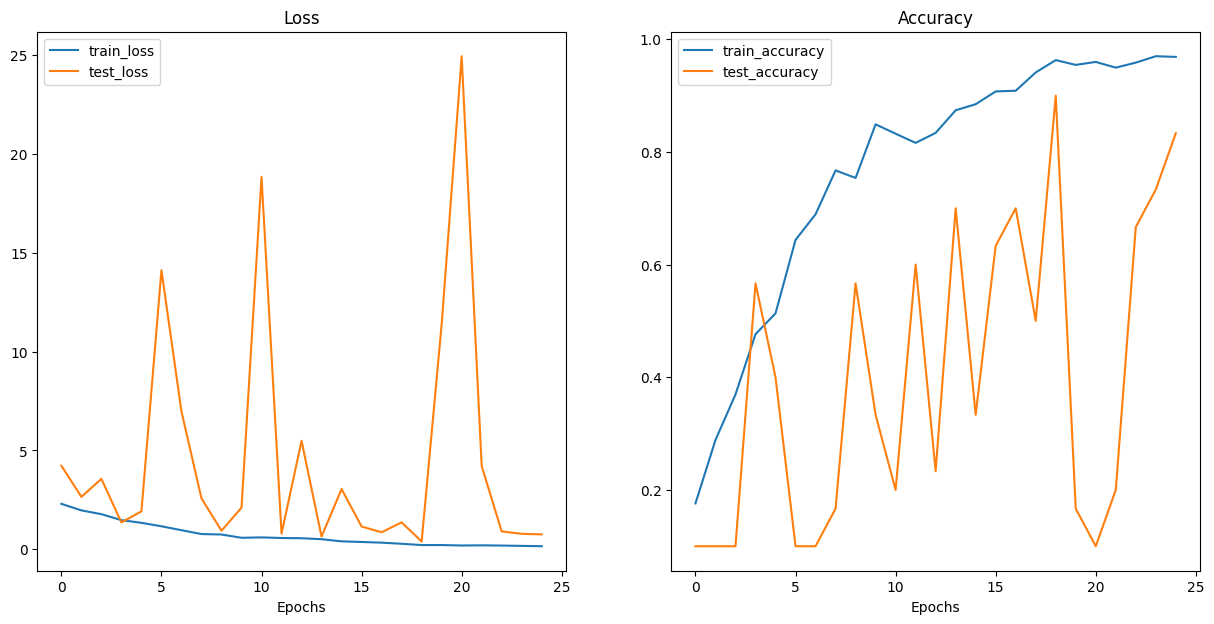

In [175]:
plot_loss_curves(model_resnet_results)
# plot_loss_curves(model_VGG_results)

### Test model on custom image

In [197]:
import torchvision
from torchvision import transforms
from PIL import Image

custom_image_path = "./images/cropped/02.jpg"
# custom_image_path = "./data/CATANIST V1/test/five/01.jpg"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
# print(f"Custom image tensor:\n{custom_image_uint8}\n")
# print(f"Custom image shape: {custom_image_uint8.shape}\n")
# print(f"Custom image dtype: {custom_image_uint8.dtype}")

In [198]:
# Making a prediction given the image
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255

In [199]:
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=3)
])

custom_image_transformed = custom_image_transform(custom_image[:3, :, :])

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 64, 64])
New shape: torch.Size([3, 64, 64])


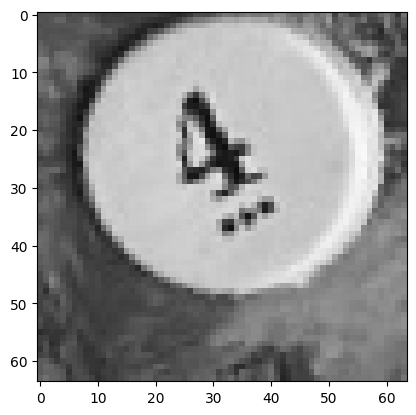

In [200]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [201]:
model_resnet.eval()
with torch.inference_mode():
    custom_image_pred = model_resnet(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

# ([[ 16.9660,  -9.9047,   3.6385, -17.2219,  -0.3486,   5.3426,   8.0146,
#          -13.0720,  -6.2594, -18.9267]], device='mps:0')

tensor([[-1.4690, -1.9375,  0.2990, -0.6057, -1.5966, -0.0751, -3.7897,  0.2617,
         -1.3998, -5.4560]], device='mps:0')

In [204]:
# Print out prediction logits
# print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
# print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")
print(f"Prediction class: {class_names[custom_image_pred_label]}")
print(class_names)

Prediction label: tensor([2], device='mps:0')
Prediction class: five
['eight', 'eleven', 'five', 'four', 'nine', 'six', 'ten', 'three', 'twelve', 'two']


# Save the model

In [203]:
from pathlib import Path 

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create the model save path
MODEL_NAME = "catanist_resnet2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_resnet.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/catanist_resnet2.pth
